In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm import tqdm_notebook
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys,psutil
from collections import Counter

In [82]:
from zac_pyutils import ExqUtils
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle
from xgboost import plot_importance

In [32]:
%run loadUtil.py # 基础工具类

# Other

## 测试 | ExqUtils工具类

In [ ]:
fileIter = ExqUtils.load_file_as_iter("./data/nlp/sample_data.txt")
def func(iter_list): return [i.split("\t") for i in iter_list]
ExqUtils.map_on_iter(fileIter,func,chunk_size=5)

## 测试 | pd处理数据
- 分块读取
- 行、列处理
- 各块数据append保存
    - 注意append保存时，header务必写false，不让每个chunk都会写一个header

In [48]:
df_chunkList = pd.read_csv("./data/nlp/sample_data.txt", 
            delimiter="\t",
            names=['id','label','weight','feature'],
            chunksize=5,
#             iterator=False,
           )

def my_test(a,b): return str(a)+"\t"+str(b)

for chunk in df_chunkList:
    chunk['feature'] = chunk['feature'].map(lambda x: x.split(","))
    chunk['id+label'] = chunk.apply(lambda row: my_test(row['id'],row['label']),axis=1)
    chunk.to_csv("./data/nlp/sample_data_processed.txt",mode='a',sep='\t',header=False)
    
df_load = pd.read_csv("./data/nlp/sample_data_processed.txt",delimiter="\t",names=['id','label','weight','feature',"label+feature"])
df_load['feature'].map(lambda r: [float(i) for i in eval(r)])


0    [-211382657822.72, 191367567861.76, 1372984720...
1    [-33325875745.53254, 124329209956.61206, 12401...
2    [-33325875745.53254, 124329209956.61206, 12401...
3    [-35363378566.72146, 174563844459.54337, 11503...
4    [-35363378566.72146, 174563844459.54337, 11503...
5    [-54163746911.075, 97957695487.78902, 85072685...
6    [-50780992354.85994, 143699497487.83133, 13999...
7    [-31902283089.65517, 186908710882.5747, 146082...
8    [-50814519757.92308, 66373391832.0, 9546597701...
9    [-50814519757.92308, 66373391832.0, 9546597701...
0    [-211382657822.72, 191367567861.76, 1372984720...
1    [-33325875745.53254, 124329209956.61206, 12401...
2    [-33325875745.53254, 124329209956.61206, 12401...
3    [-35363378566.72146, 174563844459.54337, 11503...
4    [-35363378566.72146, 174563844459.54337, 11503...
5    [-54163746911.075, 97957695487.78902, 85072685...
6    [-50780992354.85994, 143699497487.83133, 13999...
7    [-31902283089.65517, 186908710882.5747, 146082...
8    [-508

# XGB | DMatrix 

## load

### 说明 | 各种数据加载为DMatrix形式
- libsvm
```
dtrain = xgb.DMatrix('train.svm.txt')
dtest = xgb.DMatrix('test.svm.buffer')
```
- csv
````
xgb.DMatrix("train.csv?format=csv&label_column=0")
```
- numpy
```
data = np.random.rand(5,10)
label = np.random.randint(2,size=5)
dtrain = xgb.DMatrix(data, label=label)
```
- scipy
```
csr = scipy.sparse.csr_matrix((data, (row, col)))
dtrain = xgb.DMatrix(csr)
```
- pandas df
```
data = pd.DataFrame(np.arange(12).reshape((4,3)), columns=['a','b','c'])
label = pd.DataFrame(np.random.randint(2, size=4))
dtrain = xgb.DMatrix(data, label=label)
```

### pre-process | pd加载csv然后导入DMatrix

In [113]:
label = loadUtil.loadSampleCSV()['label'].values
weight = loadUtil.loadSampleCSV()['weight'].values
feature = loadUtil.loadSampleCSV()['feature'].map(lambda x: [eval(i) for i in x.split(",")]).values
feature = np.asarray(feature.tolist())
train = xgb.DMatrix(data=feature,weight=weight,label=label)

## train

### 自定义评价函数和目标函数

In [ ]:
def my_eval(preds,dtrain):
    label=dtrain.get_label()
    preds = 1.0/(1.0+np.exp(-preds)) # 输出sigmoid一下
    pred = [int(i >= 0.5) for i in preds]
    tp = sum([int(i == 1 and j == 1) for i,j in zip(pred,label)])
    precision=float(tp)/sum(pred)
    recall=float(tp)/sum(label)
    return 'f1-score',2 * ( precision*recall/(precision+recall) )

def my_obj(y_pre,dtrain):
    label=dtrain.get_label()
    penalty=2.0
    grad=-label/y_pre+penalty*(1-label)/(1-y_pre) #梯度
    hess=label/(y_pre**2)+penalty*(1-label)/(1-y_pre)**2 #2阶导
    return grad,hess

### 训练

#### eval_metric部分参数 [default according to objective]
- `rmse`: root mean square error
- `mae`: mean absolute error
- `logloss`: negative log-likelihood
- `auc`: Area under the curve
- `map`: Mean Average Precision
- `cox-nloglik`: negative partial log-likelihood for Cox proportional hazards regression

#### objective部分参数
- 回归类
    - `reg:squarederror`: regression with squared loss
    - `reg:logistic`: logistic regression
    - `reg:gamma`: gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.
    - `reg:tweedie`: Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.
    - `reg:linear` : ???
- 二分类
    - `binary:logistic`: logistic regression for binary classification, output probability
    - `binary:logitraw`: logistic regression for binary classification, output score before logistic transformation
    - `binary:hinge`: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
- 分布预测（这里是泊松分布）
    – `poisson regression` for count data, output mean of poisson distribution
    - `max_delta_step` is set to 0.7 by default in poisson regression (used to safeguard optimization)

- `survival:cox`: Cox regression for right censored survival time data (negative values are considered right censored). Note that predictions are returned on the hazard ratio scale (i.e., as HR = exp(marginal_prediction) in the proportional hazard function h(t) = h0(t) * HR).

- 多分类
    - `multi:softmax`: set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
    - `multi:softprob`: （输出的是概率矩阵）same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.

- 排序
    - `rank:pairwise`: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized
    - `rank:ndcg`: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized
    - `rank:map`: Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized


In [ ]:
num_round = 100
param = {
    'max_depth':5,
    'eta':0.9,
    'verbosity':3,
    'objective':'reg:linear',
    'nthread':4,
    'eval_metric':['auc']
}
bst = xgb.train(param, dtrain, num_round, evallist,feval=f1_error)

## 模型持久化

In [ ]:
bst.save_model("./data/nlp/xgb_model.bin")
# dump得到的是info信息，后续不能直接拿来predict
bst.dump_model("./data/nlp/xgb_model.json",dump_format="json")
bst.dump_model("./data/nlp/xgb_model.txt",dump_format="text")

## infer/predict

In [ ]:
bst_load = xgb.Booster({'nthread':4}) # init model
bst_load.load_model("/home/zhoutong/xgb_001.model.bin") # load data
bst.predict(data)

## analyze

### 可视化

In [ ]:
xgb.plot_importance(bst_load)

### 特征重要度
importance_type:
- ‘weight’ - the number of times a feature is used to split the data across all trees.
- ‘gain’ - the average gain across all splits the feature is used in.
- ‘cover’ - the average coverage across all splits the feature is used in.
- ‘total_gain’ - the total gain across all splits the feature is used in.
- ‘total_cover’ - the total coverage across all splits the feature is used in.

In [ ]:
feat_imp_gain=bst.get_score(importance_type='gain')
feat_imp = bst.get_score(importance_type='weight')
feat_imp['f123345']
feat_imp_gain['f123345']

# XGB | Sklearn

## load

In [58]:
# df = loadUtil.loadDataCSV() # 正式数据
df = loadUtil.loadSampleCSV() # 10条样例数据
label = df['label'].values
weight = df['weight'].values
feature = df['feature'].map(lambda x: [eval(i) for i in x.split(",")]).values
feature = np.asarray(feature.tolist())
feature
print("label分类情况：",Counter(label))

array([[-2.11382658e+11,  1.91367568e+11,  1.37298472e+11, ...,
        -1.73583368e+11, -1.55742669e+11,  1.57820631e+11],
       [-3.33258757e+10,  1.24329210e+11,  1.24019984e+11, ...,
         7.49401047e+10,  5.53350398e+11, -1.65066818e+11],
       [-3.33258757e+10,  1.24329210e+11,  1.24019984e+11, ...,
        -1.23697357e+11,  5.07993088e+10, -2.04650562e+11],
       ...,
       [-4.54710271e+10,  1.34911006e+11,  1.14968763e+11, ...,
        -8.50839082e+10,  1.08124771e+11,  2.27753379e+11],
       [-4.54710271e+10,  1.34911006e+11,  1.14968763e+11, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.54710271e+10,  1.34911006e+11,  1.14968763e+11, ...,
         2.74411999e+11,  8.60604006e+09, -7.41707551e+10]])

label分类情况： Counter({1: 57, 0: 53})


## train & infer/predict

### 方式一 | KFold

In [35]:
model_param = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 20,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'nthread': None,
}
train_param = {
    'eval_set': None,
    'eval_metric': None,
}

# 1/n_splits 比例的样本作为测试集，重复n_splits（即所有样本都作为测试集迭代过）
kf = KFold(n_splits=3,shuffle=True,random_state=2019)
for (train_index, test_index) in kf.split(feature):
#     print("\n\ntrain&test index:",train_index,test_index)
    train_param['X'] = feature[train_index]
    train_param['y'] = label[train_index]
    train_param['sample_weight'] = weight[train_index]
    xgb_model = xgb.XGBClassifier(**model_param).fit(**train_param)
    predictions = xgb_model.predict(feature[test_index])
    print("confusion_matrix:\n",confusion_matrix(label[test_index], predictions))

confusion_matrix:
 [[11  6]
 [ 9 11]]
confusion_matrix:
 [[14  5]
 [ 9  9]]
confusion_matrix:
 [[11  6]
 [ 4 15]]


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 方式二 | GridSearchCV

In [44]:
model_param = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 20,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'nthread': None,
}
train_param = {
    'X': feature,
    'y': label,
    'eval_set': None,
    'eval_metric': None,
}
xgb_model = xgb.XGBRegressor(**model_param)

params_grid = {
    'max_depth': [1,2,3,4,5,6],
    'n_estimators': [10,15,20,50,52,55,60,70,80],
}
clf = GridSearchCV(xgb_model, params_grid, verbose=1, cv=4, scoring='roc_auc')
clf.fit(feature,label,sample_weight=weight)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   17.4s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6], 'n_estimators': [10, 15, 20, 50, 52, 55, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

#### clf的迭代信息

In [45]:
def log_details(searcher):
    print(">>> searcher.param_grid:\n",searcher.param_grid)
    print(">>> searcher.best_score_:\n",searcher.best_score_)
    print(">>> searcher.best_params_:\n",searcher.best_params_)

    print(">>> searcher.cv_results_:\n")
    targetItems = [
        'mean_train_score','mean_test_score',
    #     'mean_fit_time','mean_score_time',
    ]
    for i in range(0,len(searcher.cv_results_['params'])):
        cur_param = searcher.cv_results_['params'][i]
        print(",".join([item+": "+"{:.3f}".format(searcher.cv_results_[item][i]) for item in targetItems])+f", {cur_param}")
        
log_details(clf)

>>> searcher.param_grid:
 {'max_depth': [1, 2, 3, 4, 5, 6], 'n_estimators': [10, 15, 20, 50, 52, 55, 60, 70, 80]}
>>> searcher.best_score_:
 0.7730999837951709
>>> searcher.best_params_:
 {'max_depth': 1, 'n_estimators': 60}
>>> searcher.cv_results_:

mean_train_score: 0.936,mean_test_score: 0.648, {'max_depth': 1, 'n_estimators': 10}
mean_train_score: 0.959,mean_test_score: 0.698, {'max_depth': 1, 'n_estimators': 15}
mean_train_score: 0.974,mean_test_score: 0.705, {'max_depth': 1, 'n_estimators': 20}
mean_train_score: 0.998,mean_test_score: 0.747, {'max_depth': 1, 'n_estimators': 50}
mean_train_score: 0.998,mean_test_score: 0.758, {'max_depth': 1, 'n_estimators': 52}
mean_train_score: 0.999,mean_test_score: 0.758, {'max_depth': 1, 'n_estimators': 55}
mean_train_score: 1.000,mean_test_score: 0.773, {'max_depth': 1, 'n_estimators': 60}
mean_train_score: 1.000,mean_test_score: 0.754, {'max_depth': 1, 'n_estimators': 70}
mean_train_score: 1.000,mean_test_score: 0.760, {'max_depth': 1, 'n_

/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## 模型持久化

In [235]:
pickle.dump(clf, open("/home/zhoutong/data/nlp/best_from_clf.xgb.pkl", "wb"))
# 下面是检验一下模型保存后load出来是否还和之前一样
# clf2 = pickle.load(open("./data/nlp/best_from_clf.xgb.pkl", "rb"))
# print(np.allclose(clf.predict(feature), clf2.predict(feature)))

# 正式Demo | 使用外部真实数据

In [83]:
from zac_pyutils import ExqUtils
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn import metrics
from xgboost import plot_importance

## prepare

In [62]:
path_test = "/home/zhoutong/data/nlp/tagged_corpus_byW2V_id_label_weight_feat_6.9w.txt"
path_train = "/home/zhoutong/data/nlp/tagged_corpus_byW2V_id_label_weight_feat_28w.txt"
df_test = pd.read_csv(path_test, delimiter="\t", names=['id','label','weight','feature'])
df_train = pd.read_csv(path_train, delimiter="\t", names=['id','label','weight','feature'])
df = pd.concat([df_test,df_train])
label = df['label'].values
weight = df['weight'].values
feature = df['feature'].map(lambda x : [float(i) for i in x.split(",")]).values
feature = np.asarray(feature.tolist())
df.head(2)
df.shape
feature[:2]

,id,label,weight,feature
0,1547316214767546,0,1.0,"-2.1138265782272E11,1.9136756786176E11,1.37298..."
1,1547359265142185,1,1.5,"-3.332587574553254E10,1.2432920995661206E11,1...."


(350067, 4)

array([[-2.11382658e+11,  1.91367568e+11,  1.37298472e+11, ...,
        -1.73583368e+11, -1.55742669e+11,  1.57820631e+11],
       [-3.33258757e+10,  1.24329210e+11,  1.24019984e+11, ...,
         7.49401047e+10,  5.53350398e+11, -1.65066818e+11]])

## by GridSearchCV

### model 

In [67]:
model_param = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 20,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'nthread': None,
}
train_param = {
    'eval_set': None,
    'eval_metric': None,
}
xgb_model = xgb.XGBClassifier(**model_param)
params_grid = {
    'max_depth': [2,4],
    'n_estimators': [10,50,70,100],
    'learning_rate': [0.001,0.02,0.1]
}
# clf = GridSearchCV(xgb_model, params_grid, verbose=1, cv=4, scoring=['roc_auc','f1'],refit='roc_auc')
clf = GridSearchCV(xgb_model, params_grid, verbose=2, cv=3, scoring='roc_auc')


### fit

In [68]:
clf.fit(feature,label,sample_weight=weight)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.001, max_depth=2, n_estimators=10 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=10, total=  37.8s
[CV] learning_rate=0.001, max_depth=2, n_estimators=10 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.0s remaining:    0.0s


[CV]  learning_rate=0.001, max_depth=2, n_estimators=10, total=  38.7s
[CV] learning_rate=0.001, max_depth=2, n_estimators=10 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=10, total=  38.7s
[CV] learning_rate=0.001, max_depth=2, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=50, total= 2.5min
[CV] learning_rate=0.001, max_depth=2, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=50, total= 2.6min
[CV] learning_rate=0.001, max_depth=2, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=50, total= 2.6min
[CV] learning_rate=0.001, max_depth=2, n_estimators=70 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=70, total= 3.4min
[CV] learning_rate=0.001, max_depth=2, n_estimators=70 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=70, total= 3.5min
[CV] learning_rate=0.001, max_depth=2, n_estimators=70 ...............
[CV]  

[CV]  learning_rate=0.02, max_depth=2, n_estimators=100, total= 4.9min
[CV] learning_rate=0.02, max_depth=4, n_estimators=10 ................
[CV] . learning_rate=0.02, max_depth=4, n_estimators=10, total= 1.2min
[CV] learning_rate=0.02, max_depth=4, n_estimators=10 ................
[CV] . learning_rate=0.02, max_depth=4, n_estimators=10, total= 1.2min
[CV] learning_rate=0.02, max_depth=4, n_estimators=10 ................
[CV] . learning_rate=0.02, max_depth=4, n_estimators=10, total= 1.2min
[CV] learning_rate=0.02, max_depth=4, n_estimators=50 ................
[CV] . learning_rate=0.02, max_depth=4, n_estimators=50, total= 5.3min
[CV] learning_rate=0.02, max_depth=4, n_estimators=50 ................
[CV] . learning_rate=0.02, max_depth=4, n_estimators=50, total= 5.4min
[CV] learning_rate=0.02, max_depth=4, n_estimators=50 ................
[CV] . learning_rate=0.02, max_depth=4, n_estimators=50, total= 5.4min
[CV] learning_rate=0.02, max_depth=4, n_estimators=70 ................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 322.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4], 'n_estimators': [10, 50, 70, 100], 'learning_rate': [0.001, 0.1, 0.02]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

### serialize

In [69]:
pickle.dump(clf, open("/home/zhoutong/data/nlp/best_from_clf.xgb.pkl", "wb"))

/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


True


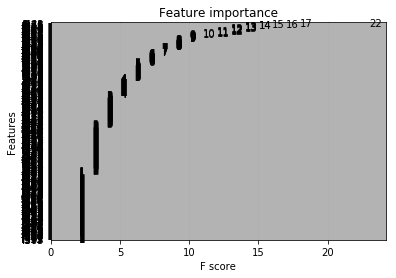

In [89]:
clf2 = pickle.load(open("/home/zhoutong/data/nlp/best_from_clf.xgb.pkl", "rb"))
print(np.allclose(clf.predict(feature), clf2.predict(feature)))
plot_importance(clf2.best_estimator_)

In [70]:
def log_details(searcher):
    print(">>> searcher.param_grid:\n",searcher.param_grid)
    print(">>> searcher.best_score_:\n",searcher.best_score_)
    print(">>> searcher.best_params_:\n",searcher.best_params_)

    print(">>> searcher.cv_results_:\n")
    targetItems = [
        'mean_train_score','mean_test_score',
    #     'mean_fit_time','mean_score_time',
    ]
    for i in range(0,len(searcher.cv_results_['params'])):
        cur_param = searcher.cv_results_['params'][i]
        print(",".join([item+": "+"{:.3f}".format(searcher.cv_results_[item][i]) for item in targetItems])+f", {cur_param}")
        
log_details(clf)

>>> searcher.param_grid:
 {'max_depth': [2, 4], 'n_estimators': [10, 50, 70, 100], 'learning_rate': [0.001, 0.1, 0.02]}
>>> searcher.best_score_:
 0.87309608839325
>>> searcher.best_params_:
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
>>> searcher.cv_results_:

mean_train_score: 0.691,mean_test_score: 0.691, {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 10}
mean_train_score: 0.714,mean_test_score: 0.714, {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 50}
mean_train_score: 0.714,mean_test_score: 0.714, {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 70}
mean_train_score: 0.725,mean_test_score: 0.724, {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100}
mean_train_score: 0.752,mean_test_score: 0.751, {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 10}
mean_train_score: 0.771,mean_test_score: 0.770, {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 50}
mean_train_score: 0.776,mean_test_score: 0.775, {'learning_rate': 

/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## by KFold & Manual

### model

In [77]:
model_param = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 4,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'nthread': None,
}
train_param = {
    'eval_set': None,
    'eval_metric': None,
}

### fit

In [93]:
kf = KFold(n_splits=6,shuffle=True,random_state=2019)
for (train_index, test_index) in kf.split(feature):
    print(f"train: {len(train_index)}, test: {len(test_index)}")
#     train_param['X'] = feature[train_index]
#     train_param['y'] = label[train_index]
#     train_param['sample_weight'] = weight[train_index]
#     xgb_model = xgb.XGBClassifier(**model_param).fit(**train_param)
    predictions = clf2.best_estimator_.predict(feature[test_index])
    print("roc_auc_score:\n",metrics.roc_auc_score(label[test_index], predictions))

train: 291722, test: 58345


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


roc_auc_score:
 0.7841196313904862
train: 291722, test: 58345


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


roc_auc_score:
 0.7874845850589687
train: 291722, test: 58345


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


roc_auc_score:
 0.7874166061211095
train: 291723, test: 58344


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


roc_auc_score:
 0.7832215337911104
train: 291723, test: 58344


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


roc_auc_score:
 0.7863814693698296
train: 291723, test: 58344
roc_auc_score:
 0.7862485774520889


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
